<a href="https://colab.research.google.com/github/KayMichnicki/Computer-Vision-Project-Tomato-Leave-Disease-Detection/blob/main/AAI521_Computer_Vision_Final_Project_Tomato_Leaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries used in this project** **bold text**

In [238]:
import os
import kagglehub
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Functions used in this project**

In [239]:
def display_images_by_category(base_path, num_images=5):
    """
    This function is to display a few images from each category in a directory structure.
    """
    try:
        categories = os.listdir(base_path)

        for category in categories:
            category_path = os.path.join(base_path, category)

            if not os.path.isdir(category_path):
                continue

            image_files = []
            for root, _, files in os.walk(category_path):
                for file in files:
                    if file.endswith(('.png', '.jpg', '.jpeg')):
                        image_files.append(os.path.join(root, file))

            if not image_files:
                print(f"No images found in category: {category}")
                continue

            print(f"Category: {category}")

            for i, img_path in enumerate(image_files[:num_images]):
                img = imread(img_path)
                plt.imshow(img)
                plt.title(f"{category} - Image {i + 1}")
                plt.axis('off')
                plt.show()

    except Exception as e:
        print(f"There is an error: {e}")

# Import Data




In [240]:
dataset_path = kagglehub.dataset_download("ashishmotwani/tomato")
print("Path to dataset files:", dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1


## View sample images

Category: train


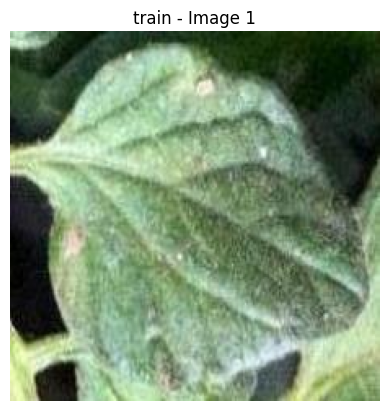

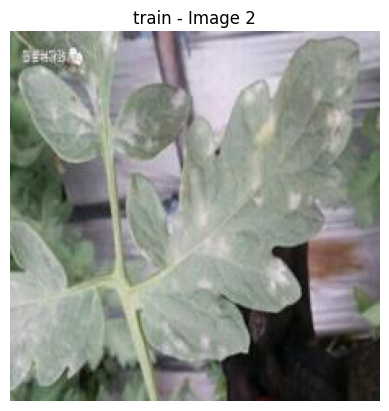

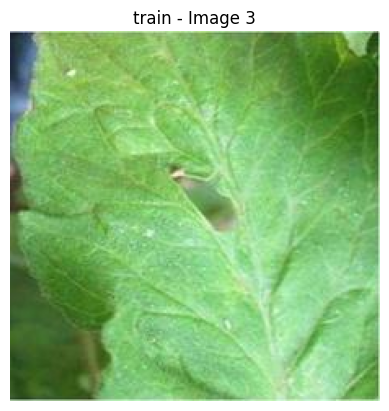

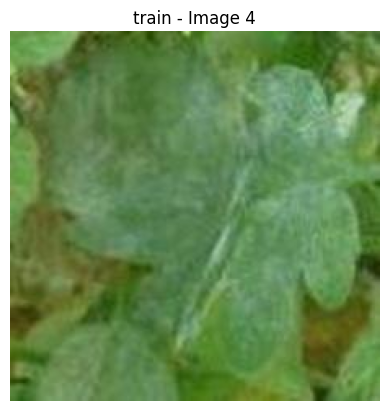

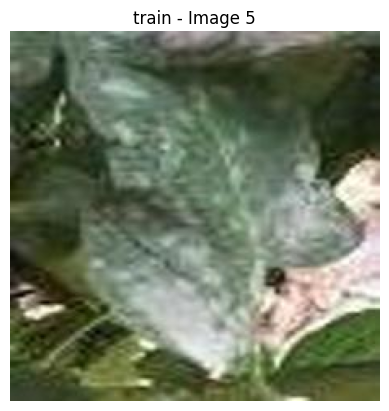

Category: valid


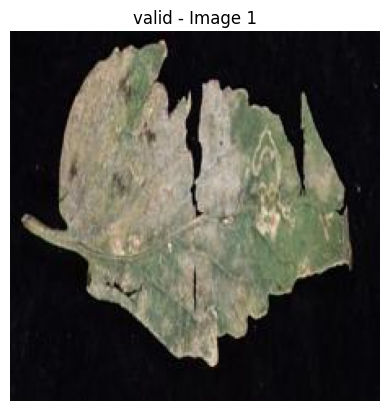

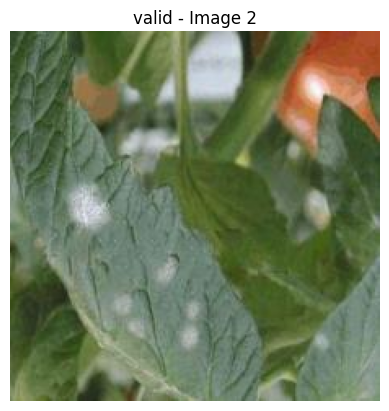

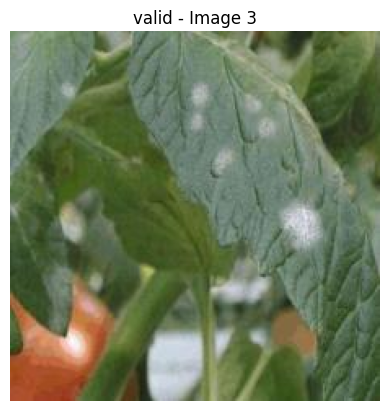

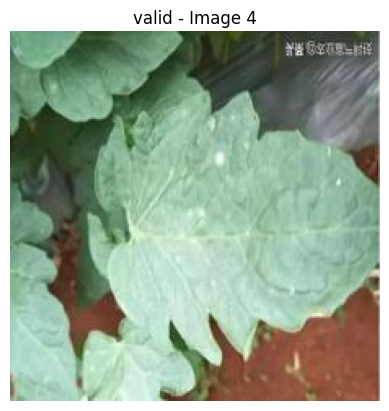

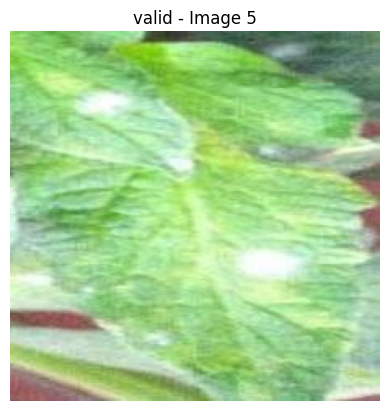

In [241]:
display_images_by_category(path, num_images=5)

In [260]:
path

'/root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1'

In [261]:
dataset_path

'/root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1'

In [242]:
# View all categories in train and validation data:
for category in os.listdir(path):
    category_path = os.path.join(path, category)
    if os.path.isdir(category_path):
        print(f"Category: {category}")
        print("Number of categories:", len(os.listdir(category_path)))
        files = os.listdir(category_path)
        print(f"Files: {files}")

Category: train
Number of categories: 11
Files: ['powdery_mildew', 'Septoria_leaf_spot', 'Target_Spot', 'Leaf_Mold', 'Tomato_mosaic_virus', 'Late_blight', 'Spider_mites Two-spotted_spider_mite', 'Early_blight', 'Tomato_Yellow_Leaf_Curl_Virus', 'healthy', 'Bacterial_spot']
Category: valid
Number of categories: 11
Files: ['powdery_mildew', 'Septoria_leaf_spot', 'Target_Spot', 'Leaf_Mold', 'Tomato_mosaic_virus', 'Late_blight', 'Spider_mites Two-spotted_spider_mite', 'Early_blight', 'Tomato_Yellow_Leaf_Curl_Virus', 'healthy', 'Bacterial_spot']


### Split training and validation data and resizing the data

In [243]:
# Load the entire dataset and reserve 20% for testing
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # Reserve 10% for testing
    subset="training",     # Initially load 90% as "training + validation"
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",   # This becomes the "test" dataset
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 32534 files belonging to 2 classes.
Using 26028 files for training.
Found 32534 files belonging to 2 classes.
Using 6506 files for validation.


In [244]:
len(train_dataset)

814

In [245]:
len(validation_dataset)

204

In [246]:
def display_samples(dataset, title, num_samples=9):
    """
    Display a grid of images with their labels from a given dataset.
    """
    # Take 1 batch of data from the dataset
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()

        # Integers in the range [0, 255]
        images = images.clip(0, 255)
        images = images.astype("uint8")
        break

    # Plotting setup
    grid_size = int(num_samples**0.5)
    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=16)

    # Plot the images with labels
    for i in range(min(num_samples, len(images))):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

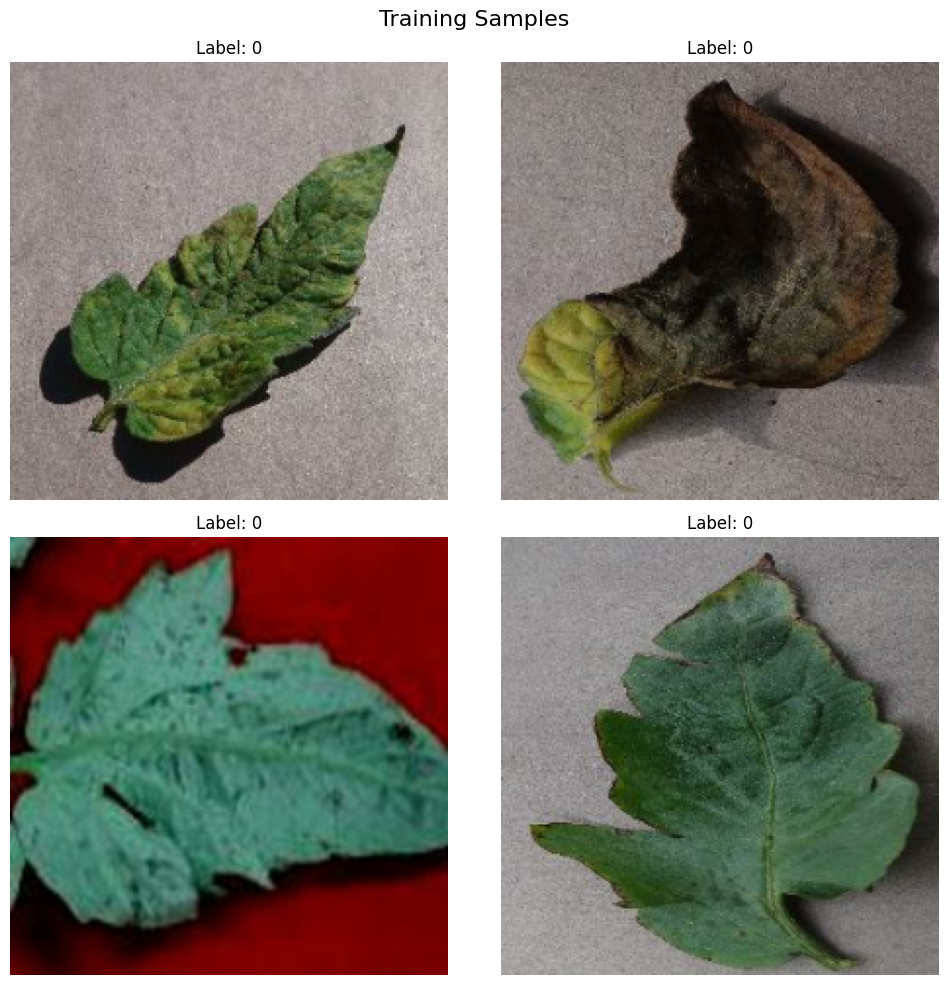

In [247]:
display_samples(train_dataset, "Training Samples", 4)

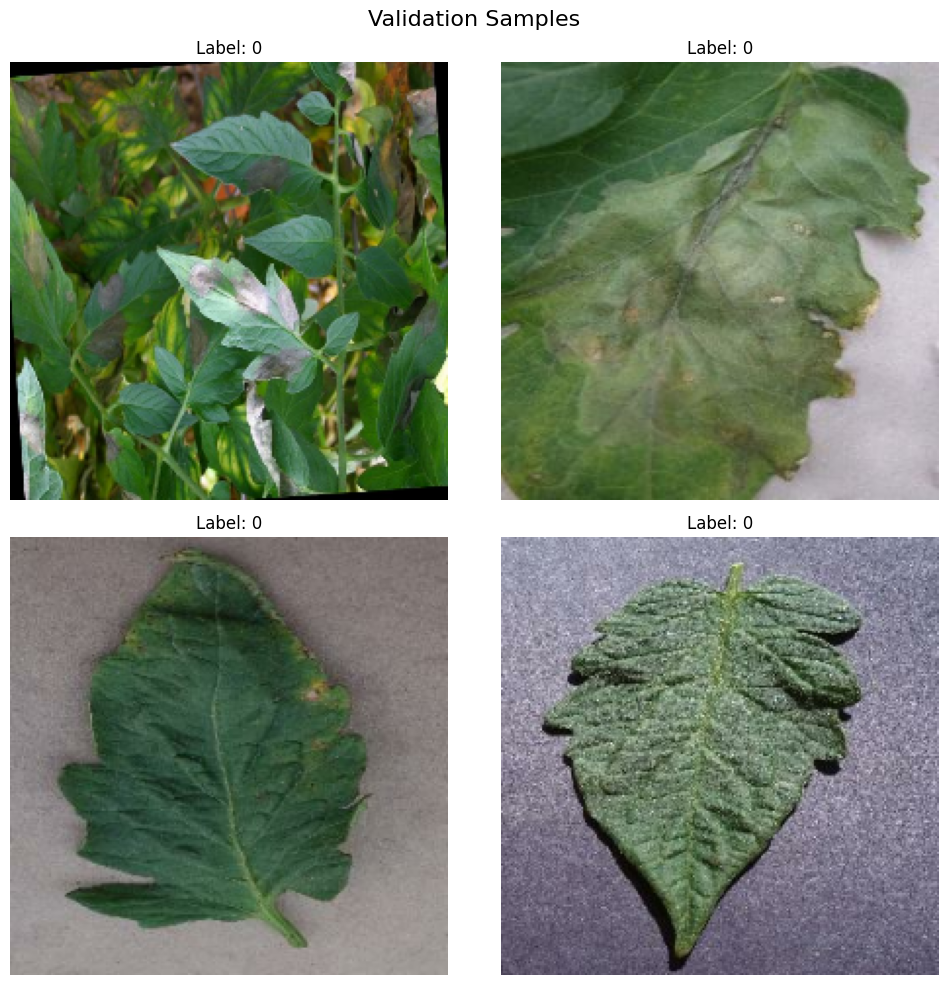

In [248]:
display_samples(validation_dataset, "Validation Samples", 4)

## Image Processing

### Normalize dataset

Normalization so that the pixel values in most images are represented as integers between 0 and 255, and scaling them to [0, 1] helps a CNN model train more effectively by standardizing the input range.

In [249]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset_normalized = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset_normalized = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

In [250]:
# verify that values are between 0 and 1.
import numpy as np

for images, labels in train_dataset_normalized.take(1):
    image_np = images[0].numpy()
    subset = image_np[20:25, 20:25, 0]
    tensor_subset = tf.convert_to_tensor(subset)
    print(tensor_subset)
    break

tf.Tensor(
[[0.7467587  0.7568028  0.7559024  0.75306123 0.7456583 ]
 [0.7644259  0.78465384 0.76852745 0.7601441  0.76274514]
 [0.7762506  0.7485795  0.7468588  0.7512806  0.7623249 ]
 [0.77825135 0.74051625 0.7439376  0.7511005  0.7593838 ]
 [0.7780113  0.7607844  0.759944   0.7561625  0.7539216 ]], shape=(5, 5), dtype=float32)


## Data Augmentation

Dat augmentation is used to prevent overffing by adding variability to the training data. This medthod improve generalization by helping the model learn features that are in various different orientations, scale and position. The following transformations are applied to enhance dataset diversity:

- Geometric Transformations: Flip, rotate, crop, or resize.

- Color Adjustments: Change brightness, contrast, saturation, or apply grayscale.

- Noise Injection: Add random noise for robustness.

- Distortions: Apply random zoom, shear, or perspective transformations.

In [251]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

In [252]:
import tensorflow as tf
from tensorflow.keras.layers import (
    RandomFlip, RandomRotation, RandomZoom, RandomCrop, RandomTranslation,
    Rescaling, RandomContrast, RandomBrightness
)

data_augmentation = tf.keras.Sequential([
    # Geometric Transformations
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomCrop(height=200, width=200),
    RandomTranslation(height_factor=0.1, width_factor=0.1),

    # Color Adjustments
    RandomBrightness(factor=0.2),
    RandomContrast(factor=0.2),

    # Normalize image values to the range [0, 1]
    Rescaling(1.0 / 255),

    # Distortions
    RandomZoom(height_factor=0.0, width_factor=(-0.3, 0.3))
])

In [253]:
# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

## Label Encoding

Categorical Labels: Convert class names into integers or one-hot encoding for classification tasks.

In [254]:
# List of categories
categories = [
    'powdery_mildew', 'Septoria_leaf_spot', 'Target_Spot', 'Leaf_Mold',
    'Tomato_mosaic_virus', 'Late_blight', 'Spider_mites Two-spotted_spider_mite',
    'Early_blight', 'Tomato_Yellow_Leaf_Curl_Virus', 'healthy', 'Bacterial_spot'
]

# Create a dictionary for label encoding
label_mapping = {name: idx for idx, name in enumerate(categories)}

print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'powdery_mildew': 0, 'Septoria_leaf_spot': 1, 'Target_Spot': 2, 'Leaf_Mold': 3, 'Tomato_mosaic_virus': 4, 'Late_blight': 5, 'Spider_mites Two-spotted_spider_mite': 6, 'Early_blight': 7, 'Tomato_Yellow_Leaf_Curl_Virus': 8, 'healthy': 9, 'Bacterial_spot': 10}


In [255]:
# Labels for train dataset
train_labels =  categories

# Encode labels
encoded_train_labels = [label_mapping[label] for label in train_labels]

print("Encoded Train Labels:")
print(encoded_train_labels)

Encoded Train Labels:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [256]:
# Labels for train dataset
val_labels =  categories

# Encode labels
encoded_val_labels = [label_mapping[label] for label in val_labels]

print("Encoded Validation Labels:")
print(encoded_val_labels)

Encoded Validation Labels:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [257]:
# Map encoded labels to TensorFlow dataset
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=len(categories))))

# Verify the labels
for images, labels in train_dataset.take(1):
    print("One-hot Encoded Labels:")
    print(labels.numpy())

One-hot Encoded Labels:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1.

In [258]:
len(train_dataset)

814

In [259]:
len(validation_dataset)

204